In [4]:
import numpy as np
import pandas as pd
import math
from collections import deque
import re
import data_loading.deque as deque
from sklearn.preprocessing import MultiLabelBinarizer
import json 

# Data Processing

In [5]:
test_df = pd.read_csv('test_3.csv')
test_df.head()

,Unnamed: 0,index,datetime,ui_language,eligible_templates,history,selected_template,session_end_completed
0,0,0,27.791771,en,['K' 'H' 'G' 'E' 'B' 'J' 'L' 'F' 'D'],"[{'template': 'D', 'n_days': 5.000000953674316...",G,0
1,1,1,30.471898,en,['K' 'H' 'G' 'E' 'B' 'J' 'L' 'F' 'D'],"[{'template': 'L', 'n_days': 1.999995470046997...",B,0
2,2,2,17.782824,en,['K' 'H' 'G' 'E' 'B' 'J' 'L' 'F' 'D'],"[{'template': 'E', 'n_days': 2.0}\n {'template...",J,0
3,3,3,18.665509,en,['K' 'H' 'G' 'E' 'B' 'J' 'L' 'F' 'D' 'A'],"[{'template': 'G', 'n_days': 24.07038879394531...",H,0
4,4,4,16.004560,en,['K' 'H' 'G' 'E' 'B' 'J' 'L' 'F' 'D'],"[{'template': 'G', 'n_days': 29.04388999938965...",F,0


## Processing history data

In [6]:
# Fix missing commas between dictionaries
test_df['history'] = test_df['history'].apply(lambda x: x.replace("}\n {", "},\n {"))


In [7]:
test_df['history'].iloc[0]

"[{'template': 'D', 'n_days': 5.000000953674316},\n {'template': 'B', 'n_days': 3.9999873638153076},\n {'template': 'G', 'n_days': 2.9999985694885254},\n {'template': 'H', 'n_days': 1.9999920129776},\n {'template': 'B', 'n_days': 0.9999986290931702}]"

In [8]:
test_df.shape

(80500, 8)

In [9]:
# Fix rows with missing commas
def fix_missing_commas(row):
    if isinstance(row, str):
        return row.replace("} {", "}, {")
    return row

test_df['history'] = test_df['history'].apply(fix_missing_commas)


# Evaluation with baseline model

In [ ]:
df = test_df
t = len(df)

# arm scores from initialized training data
arm_score = {'B': -0.0872541228157889, 'L': -0.44111089129271586, 'J': -0.113484421729121, 'A': 0.029510456125112407, 'D': -0.3008037081199235, 'E': -0.03615707682184267, 'C': -0.57968197384936, 'G': -0.12498131611641275, 'H': -0.07181379937743551, 'K': -0.07534696791696921, 'F': -0.07039644414821639}

recovering_arm = arm_score.copy()

#Defining selection probabilities
soft_max_prob = {}
total_sum = 0
baseline_sum = 0

#exploration parameter
explore = 0.5

for index, row in df.iterrows():
    arm = row['selected_template']
    
    # Parse 'history' column if it's stored as a string with single quotes
    history = row['history']
    if isinstance(history, str):
        # Replace single quotes with double quotes
        history = history.replace("'", '"')
        # Convert JSON-like string to list of dictionaries
        history = json.loads(history)

    # Reverse iterate through the history to calculate the recency penalty
    for i in history[::-1]:  # Reverse iteration for recency
    
        # Break if template is 'I' (not in training data)
        if i['template'] == 'I':
            break
        else:
            days = i['n_days']
            # Adding decay function to score for recency effect
            recovering_arm[i['template']] = (
                arm_score[i['template']] - (0.017 * 0.5) ** (days / 15)
            )

    # Computing softmax of arm scores [π (a|t)]
    paper_algo = {}
    soft_max_prob = {}
    uniform_select = {}
    
    # Parse 'eligible_templates' column if it's stored as a string with single quotes
    if isinstance(row['eligible_templates'], str):
        row['eligible_templates'] = re.findall(r"'(\w)'", row['eligible_templates'])
        

    for eligible in row['eligible_templates']:
        #Choosing at random from uniform distribution
        uniform_select[eligible] = (1/len(row['eligible_templates']))

        soft_max_prob[eligible] = math.exp(recovering_arm[eligible]/explore)

        #Calculating new policy
        sum_probs = sum(soft_max_prob.values())
        paper_algo = {arm: soft_max_prob[arm] / sum_probs for arm in soft_max_prob}

    #Getting differences in policy weights from old policy and new policy for each arm
    diff = {key: paper_algo[key] / uniform_select.get(key, 0) for key in paper_algo}

    #If reward function is 1, apply weighted multiplication of new policy
    if row['session_end_completed'] == 1:
        baseline_sum += 1
        value_to_multiply = diff.get(arm, 0)
        result = row['session_end_completed'] * value_to_multiply
        df.at[index, 'result'] = result
        total_sum += result

    #Resetting arm scores to offset recency penalty
    recovering_arm = arm_score.copy()

#final reward for sleeping and recoveriing algo
paper_reward = ((1/t)* total_sum)

# 1/number of rounds * number of successes
selected = len((df[df['session_end_completed'] == 1]))
original_reward = ((1/t)* selected)

#Measuring the difference between new and old behavior policy
rel_diff = ((paper_reward - original_reward) / ((paper_reward + original_reward)/2)) * 100

print('rel_diff: ', rel_diff) 
print('paper_reward: ', paper_reward)

rel_diff:  0.08828717316068638
paper_reward:  0.18253375359084492


In [39]:
original_reward

0.18237267080745342

# Reuse Last Template

In [10]:
import ast

# Convert the string in the `history` column into a list of dictionaries
test_df['history'] = test_df['history'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Example of accessing the last template
test_df['last_template'] = test_df['history'].apply(lambda h: h[-1]['template'] if h else None)


In [11]:
test_df.head()

,Unnamed: 0,index,datetime,ui_language,eligible_templates,history,selected_template,session_end_completed,last_template
0,0,0,27.791771,en,['K' 'H' 'G' 'E' 'B' 'J' 'L' 'F' 'D'],"[{'template': 'D', 'n_days': 5.000000953674316...",G,0,B
1,1,1,30.471898,en,['K' 'H' 'G' 'E' 'B' 'J' 'L' 'F' 'D'],"[{'template': 'L', 'n_days': 1.999995470046997...",B,0,D
2,2,2,17.782824,en,['K' 'H' 'G' 'E' 'B' 'J' 'L' 'F' 'D'],"[{'template': 'E', 'n_days': 2.0}, {'template'...",J,0,D
3,3,3,18.665509,en,['K' 'H' 'G' 'E' 'B' 'J' 'L' 'F' 'D' 'A'],"[{'template': 'G', 'n_days': 24.07038879394531...",H,0,E
4,4,4,16.004560,en,['K' 'H' 'G' 'E' 'B' 'J' 'L' 'F' 'D'],"[{'template': 'G', 'n_days': 29.04388999938965...",F,0,J


In [18]:
# Filter rows where the selected_template matches the last_template
reuse_rows = test_df[test_df['selected_template'] == test_df['last_template']]
reuse_reward = reuse_rows['session_end_completed'].sum()/ len(reuse_rows)
print(reuse_reward)


0.2050081654872074


In [22]:
rel_diff = ((reuse_reward - original_reward) / ((reuse_reward + original_reward)/2)) * 100
rel_diff

11.686429765739014

# Language UI Arm

In [ ]:
arm_score_ui = {
 ('B', 'en'): -0.8037572988068038,
 ('B', 'de'): -0.7897727272727273,
 ('B', 'fr'): -0.8170731707317074,
 ('B', 'es'): -0.8669724770642202,
 ('B', 'pt'): -0.8651817116060961,
 ('B', 'ru'): -0.8622448979591837,
 ('B', 'ja'): -0.6170212765957447,
 ('B', 'it'): -0.8133333333333334,
 ('B', 'zs'): -0.7857142857142857,
 ('B', 'hu'): -0.7543859649122807,
 ('B', 'pl'): -0.7721518987341772,
 ('B', 'ro'): -0.9166666666666666,
 ('B', 'ar'): -0.9130434782608696,
 ('B', 'el'): -1.0,
 ('B', 'cs'): -0.8360655737704918,
 ('B', 'ko'): -0.8571428571428572,
 ('B', 'dn'): -0.9333333333333333,
 ('B', 'tr'): -0.8369565217391304,
 ('B', 'id'): -1.0,
 ('B', 'vi'): -0.8823529411764706,
 ('B', 'uk'): -0.8666666666666667,
 ('B', 'th'): -1.0,
 ('B', 'hi'): -1.0,
 ('L', 'en'): -0.7933823529411765,
 ('L', 'de'): -0.772020725388601,
 ('L', 'fr'): -0.8075313807531381,
 ('L', 'es'): -0.8550497121925693,
 ('L', 'pt'): -0.8624849215922799,
 ('L', 'ru'): -0.8064516129032258,
 ('L', 'ja'): -0.7027027027027026,
 ('L', 'it'): -0.8115942028985508,
 ('L', 'zs'): -0.9444444444444444,
 ('L', 'hu'): -0.8928571428571429,
 ('L', 'pl'): -0.863013698630137,
 ('L', 'ro'): -0.6428571428571428,
 ('L', 'ar'): -0.9137931034482758,
 ('L', 'el'): -1.0,
 ('L', 'cs'): -0.8837209302325582,
 ('L', 'ko'): -1.0,
 ('L', 'dn'): -0.9285714285714286,
 ('L', 'tr'): -0.9090909090909091,
 ('L', 'id'): -1.0,
 ('L', 'vi'): -0.9285714285714286,
 ('L', 'uk'): -0.8823529411764706,
 ('L', 'th'): -1.0,
 ('L', 'hi'): -1.0,
 ('J', 'en'): -0.7952514679601737,
 ('J', 'de'): -0.7435897435897436,
 ('J', 'fr'): -0.8117154811715481,
 ('J', 'es'): -0.841745531019979,
 ('J', 'pt'): -0.8583535108958837,
 ('J', 'ru'): -0.8088888888888889,
 ('J', 'ja'): -0.6,
 ('J', 'it'): -0.7720588235294118,
 ('J', 'zs'): -0.8095238095238095,
 ('J', 'hu'): -0.8269230769230769,
 ('J', 'pl'): -0.873015873015873,
 ('J', 'ro'): -0.875,
 ('J', 'ar'): -0.921875,
 ('J', 'el'): -1.0,
 ('J', 'cs'): -0.813953488372093,
 ('J', 'ko'): -0.875,
 ('J', 'dn'): -0.7619047619047619,
 ('J', 'tr'): -0.935064935064935,
 ('J', 'id'): -1.0,
 ('J', 'vi'): -0.7945205479452055,
 ('J', 'uk'): -0.7692307692307692,
 ('J', 'th'): 0.0,
 ('J', 'hi'): -0.8,
 ('A', 'en'): -0.6477516059957173,
 ('A', 'de'): -0.5984251968503937,
 ('A', 'fr'): -0.712,
 ('A', 'es'): -0.7160647571606475,
 ('A', 'pt'): -0.7096774193548387,
 ('A', 'ru'): -0.6666666666666667,
 ('A', 'ja'): -0.4516129032258065,
 ('A', 'it'): -0.6216216216216216,
 ('A', 'zs'): -0.8076923076923077,
 ('A', 'hu'): -0.7037037037037037,
 ('A', 'pl'): -0.6111111111111112,
 ('A', 'ro'): -0.5333333333333333,
 ('A', 'ar'): -0.7391304347826086,
 ('A', 'el'): -0.6,
 ('A', 'cs'): -0.6470588235294117,
 ('A', 'ko'): -0.8,
 ('A', 'dn'): -0.5555555555555556,
 ('A', 'tr'): -0.5769230769230769,
 ('A', 'id'): -1.0,
 ('A', 'vi'): -0.7142857142857143,
 ('A', 'uk'): -0.75,
 ('A', 'th'): -1.0,
 ('A', 'hi'): 0.0,
 ('D', 'en'): -0.8004099410709711,
 ('D', 'de'): -0.7783251231527093,
 ('D', 'fr'): -0.7983870967741935,
 ('D', 'es'): -0.8408969567538708,
 ('D', 'pt'): -0.846325167037862,
 ('D', 'ru'): -0.7722772277227723,
 ('D', 'ja'): -0.5952380952380952,
 ('D', 'it'): -0.8134328358208955,
 ('D', 'zs'): -0.7222222222222222,
 ('D', 'hu'): -0.8392857142857143,
 ('D', 'pl'): -0.7105263157894737,
 ('D', 'ro'): -0.8620689655172413,
 ('D', 'ar'): -0.9622641509433962,
 ('D', 'el'): -0.75,
 ('D', 'cs'): -0.7894736842105263,
 ('D', 'ko'): -0.8571428571428572,
 ('D', 'dn'): -0.7,
 ('D', 'tr'): -0.9285714285714286,
 ('D', 'id'): -1.0,
 ('D', 'vi'): -0.8181818181818181,
 ('D', 'uk'): -0.9230769230769231,
 ('D', 'th'): -1.0,
 ('D', 'hi'): -0.5555555555555556,
 ('E', 'en'): -0.8019623031241931,
 ('E', 'de'): -0.7819148936170213,
 ('E', 'fr'): -0.7578947368421053,
 ('E', 'es'): -0.8520041109969168,
 ('E', 'pt'): -0.8790035587188612,
 ('E', 'ru'): -0.8086124401913876,
 ('E', 'ja'): -0.6060606060606061,
 ('E', 'it'): -0.85,
 ('E', 'zs'): -0.75,
 ('E', 'hu'): -0.6984126984126984,
 ('E', 'pl'): -0.6451612903225806,
 ('E', 'ro'): -0.9032258064516129,
 ('E', 'ar'): -0.8571428571428572,
 ('E', 'el'): -0.8333333333333334,
 ('E', 'cs'): -0.6470588235294117,
 ('E', 'ko'): -0.9333333333333333,
 ('E', 'dn'): -0.7,
 ('E', 'tr'): -0.875,
 ('E', 'id'): -1.0,
 ('E', 'vi'): -0.8928571428571429,
 ('E', 'uk'): -0.8,
 ('E', 'th'): -1.0,
 ('E', 'hi'): -0.9090909090909091,
 ('C', 'en'): -0.5530417295123178,
 ('C', 'de'): -0.5934959349593496,
 ('C', 'fr'): -0.5729166666666667,
 ('C', 'es'): -0.6020066889632107,
 ('C', 'pt'): -0.6503198294243071,
 ('C', 'ru'): -0.5766871165644172,
 ('C', 'ja'): -0.42307692307692313,
 ('C', 'it'): -0.46031746031746035,
 ('C', 'zs'): -0.6,
 ('C', 'hu'): -0.5957446808510638,
 ('C', 'pl'): -0.6458333333333333,
 ('C', 'ro'): -0.8125,
 ('C', 'ar'): -0.631578947368421,
 ('C', 'el'): -0.75,
 ('C', 'cs'): -0.5945945945945945,
 ('C', 'ko'): -1.0,
 ('C', 'dn'): -0.33333333333333337,
 ('C', 'tr'): -0.6785714285714286,
 ('C', 'id'): -1.0,
 ('C', 'vi'): -0.5384615384615384,
 ('C', 'uk'): -0.75,
 ('C', 'th'): -1.0,
 ('C', 'hi'): -1.0,
 ('G', 'en'): -0.816749803097926,
 ('G', 'de'): -0.7487437185929648,
 ('G', 'fr'): -0.7551020408163265,
 ('G', 'es'): -0.8547904191616766,
 ('G', 'pt'): -0.836423118865867,
 ('G', 'ru'): -0.8138528138528138,
 ('G', 'ja'): -0.5,
 ('G', 'it'): -0.8838709677419355,
 ('G', 'zs'): -0.7857142857142857,
 ('G', 'hu'): -0.7547169811320755,
 ('G', 'pl'): -0.7692307692307692,
 ('G', 'ro'): -0.8571428571428572,
 ('G', 'ar'): -0.8863636363636364,
 ('G', 'el'): -1.0,
 ('G', 'cs'): -0.75,
 ('G', 'ko'): -0.875,
 ('G', 'dn'): -0.8571428571428572,
 ('G', 'tr'): -0.925,
 ('G', 'id'): -1.0,
 ('G', 'vi'): -0.8103448275862069,
 ('G', 'uk'): -0.75,
 ('G', 'th'): -1.0,
 ('G', 'hi'): -1.0,
 ('H', 'en'): -0.809299895506792,
 ('H', 'de'): -0.7857142857142857,
 ('H', 'fr'): -0.7811320754716982,
 ('H', 'es'): -0.8369565217391304,
 ('H', 'pt'): -0.8437856328392246,
 ('H', 'ru'): -0.8018018018018018,
 ('H', 'ja'): -0.575,
 ('H', 'it'): -0.7876712328767124,
 ('H', 'zs'): -0.7741935483870968,
 ('H', 'hu'): -0.6481481481481481,
 ('H', 'pl'): -0.76,
 ('H', 'ro'): -0.75,
 ('H', 'ar'): -0.8653846153846154,
 ('H', 'el'): -0.6666666666666667,
 ('H', 'cs'): -0.7450980392156863,
 ('H', 'ko'): -0.6153846153846154,
 ('H', 'dn'): -0.8823529411764706,
 ('H', 'tr'): -0.9130434782608696,
 ('H', 'id'): -1.0,
 ('H', 'vi'): -0.7424242424242424,
 ('H', 'uk'): -0.8666666666666667,
 ('H', 'th'): -1.0,
 ('H', 'hi'): -1.0,
 ('K', 'en'): -0.8097673229353106,
 ('K', 'de'): -0.7914691943127963,
 ('K', 'fr'): -0.7993197278911565,
 ('K', 'es'): -0.8370332996972755,
 ('K', 'pt'): -0.8561320754716981,
 ('K', 'ru'): -0.8445378151260504,
 ('K', 'ja'): -0.7586206896551724,
 ('K', 'it'): -0.8257575757575757,
 ('K', 'zs'): -0.8888888888888888,
 ('K', 'hu'): -0.7735849056603774,
 ('K', 'pl'): -0.8285714285714285,
 ('K', 'ro'): -0.8648648648648649,
 ('K', 'ar'): -0.9122807017543859,
 ('K', 'el'): -0.6,
 ('K', 'cs'): -0.8,
 ('K', 'ko'): -0.8333333333333334,
 ('K', 'dn'): -0.7272727272727273,
 ('K', 'tr'): -0.8450704225352113,
 ('K', 'id'): -1.0,
 ('K', 'vi'): -0.8688524590163934,
 ('K', 'uk'): -0.8666666666666667,
 ('K', 'th'): -1.0,
 ('K', 'hi'): -0.75,
 ('F', 'en'): -0.8083877448518333,
 ('F', 'de'): -0.8112244897959184,
 ('F', 'fr'): -0.7950819672131147,
 ('F', 'es'): -0.8462717058222676,
 ('F', 'pt'): -0.8378970427163198,
 ('F', 'ru'): -0.8034934497816594,
 ('F', 'ja'): -0.6052631578947368,
 ('F', 'it'): -0.8027210884353742,
 ('F', 'zs'): -0.7428571428571429,
 ('F', 'hu'): -0.6964285714285714,
 ('F', 'pl'): -0.835820895522388,
 ('F', 'ro'): -0.7878787878787878,
 ('F', 'ar'): -0.9245283018867925,
 ('F', 'el'): -0.9166666666666666,
 ('F', 'cs'): -0.8043478260869565,
 ('F', 'ko'): -0.8333333333333334,
 ('F', 'dn'): -0.6470588235294117,
 ('F', 'tr'): -0.8309859154929577,
 ('F', 'id'): -0.7777777777777778,
 ('F', 'vi'): -0.7540983606557377,
 ('F', 'uk'): -0.7,
 ('F', 'th'): -1.0,
 ('F', 'hi'): -1.0}

In [ ]:
df = test_df
t = len(df)

recovering_arm_ui = arm_score_ui.copy()

#Defining selection probabilities
soft_max_prob = {}
total_sum = 0
baseline_sum = 0

for index, row in df.iterrows():
    arm = row['selected_template']
    
    # Parse 'history' column if it's stored as a string with single quotes
    history = row['history']
    if isinstance(history, str):
        # Replace single quotes with double quotes
        history = history.replace("'", '"')
        # Convert JSON-like string to list of dictionaries
        history = json.loads(history)

    # Reverse iterate through the history to calculate the recency penalty
    for i in history[::-1]:  # Reverse iteration for recency
    
        # Break if template is 'I' (not in training data)
        if i['template'] == 'I':
            break
        else:
            days = i['n_days']
            # Adding decay function to score for recency effect
            recovering_arm_ui[(i['template'], row['ui_language'])] = arm_score_ui[i['template'], row['ui_language']] - (0.017*0.5)**(days/15)


    # evaluation 
    paper_algo = {}
    soft_max_prob = {}
    uniform_select = {}
    
    # Parse 'eligible_templates' column if it's stored as a string with single quotes
    if isinstance(row['eligible_templates'], str):
        row['eligible_templates'] = re.findall(r"'(\w)'", row['eligible_templates'])
        

    for eligible in row['eligible_templates']:
        #Choosing at random from uniform distribution
        uniform_select[eligible] = (1/len(row['eligible_templates']))
        recovering_score = recovering_arm_ui.get(eligible, 0)
        soft_max_prob[eligible] = math.exp(recovering_score/explore)

    # Calculate new policy using argmax
    arg_max_arm = max(soft_max_prob, key=soft_max_prob.get)
    paper_algo = {arm: 1.0 if arm == arg_max_arm else 0.0 for arm in soft_max_prob}

    #Getting differences in policy weights from old policy and new policy for each arm
    diff = {key: paper_algo[key] / uniform_select.get(key, 0) for key in paper_algo}

    #If reward function is 1, apply weighted multiplication of new policy
    if row['session_end_completed'] == 1:
        baseline_sum += 1
        k = diff.get(arm, 0)
        result = row['session_end_completed'] * k
        df.at[index, 'result'] = result
        total_sum += result

    #Resetting arm scores to offset recency penalty
    recovering_arm_ui = arm_score.copy()

#Calculating reward of new behavior policy
new_reward = ((1/t)* total_sum)

#Measure reward of this baseline policy -> 1/number of rounds * number of successes
selected = len((df[df['session_end_completed'] == 1]))
original_reward = ((1/t)* selected)

#Measuring the difference between new and old behavior policy
rel_diff = ((new_reward - original_reward) / ((new_reward + original_reward)/2)) * 100
print("New Reward: ", new_reward)
print(rel_diff) 

rel_diff:  0.0
paper_reward:  0.18237267080745342


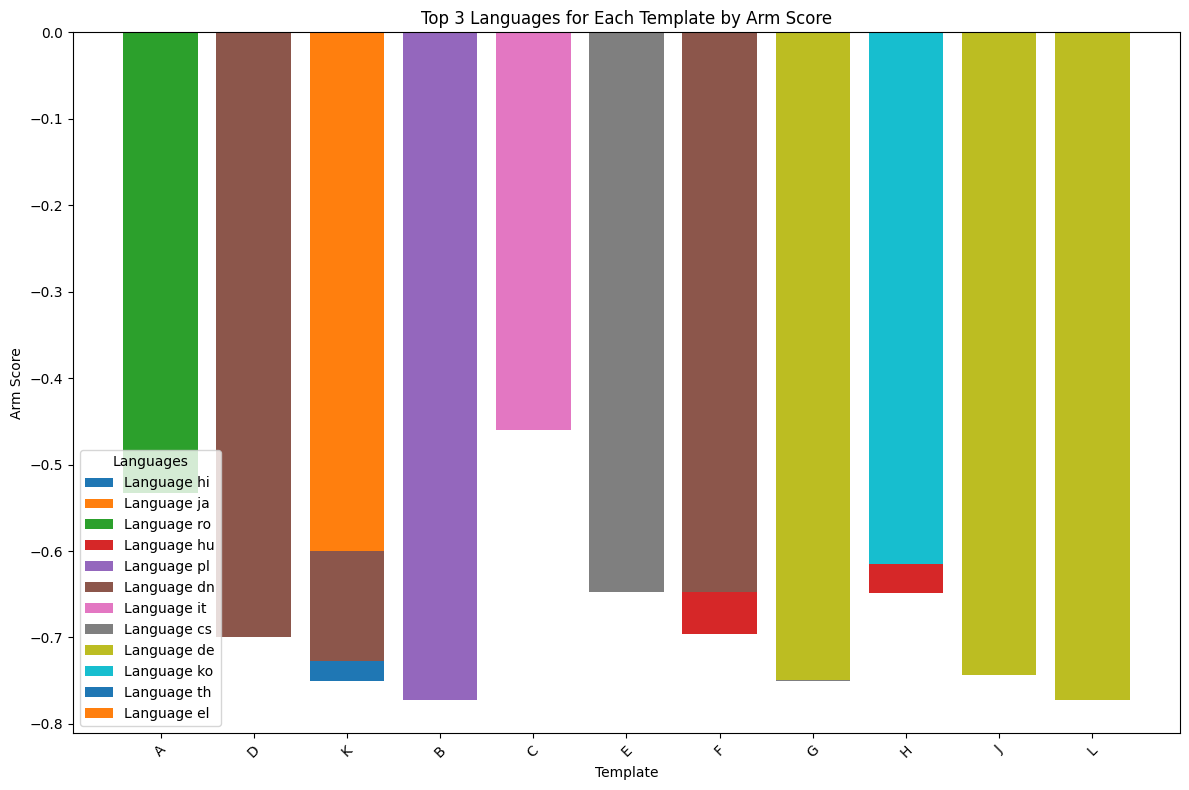

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(arm_score_ui, orient='index', columns=['score'])
df.reset_index(inplace=True)
df[['template', 'language']] = pd.DataFrame(df['index'].tolist(), index=df.index)
df.drop(columns=['index'], inplace=True)

# Get the top 3 languages for each template
top_3_per_template = df.groupby('template').apply(
    lambda x: x.nlargest(3, 'score')
).reset_index(drop=True)

# Create a plot
plt.figure(figsize=(12, 8))

# Loop through each template and plot the scores
for language in top_3_per_template['language'].unique():
    subset = top_3_per_template[top_3_per_template['language'] == language]
    plt.bar(subset['template'], subset['score'], label=f"Language {language}")

# Customize the plot
plt.title("Top 3 Languages for Each Template by Arm Score")
plt.xlabel("Template")  # Set x-axis to Template
plt.ylabel("Arm Score")
plt.xticks(rotation=45)
plt.legend(title="Languages")
plt.tight_layout()

# Show the plot
plt.show()


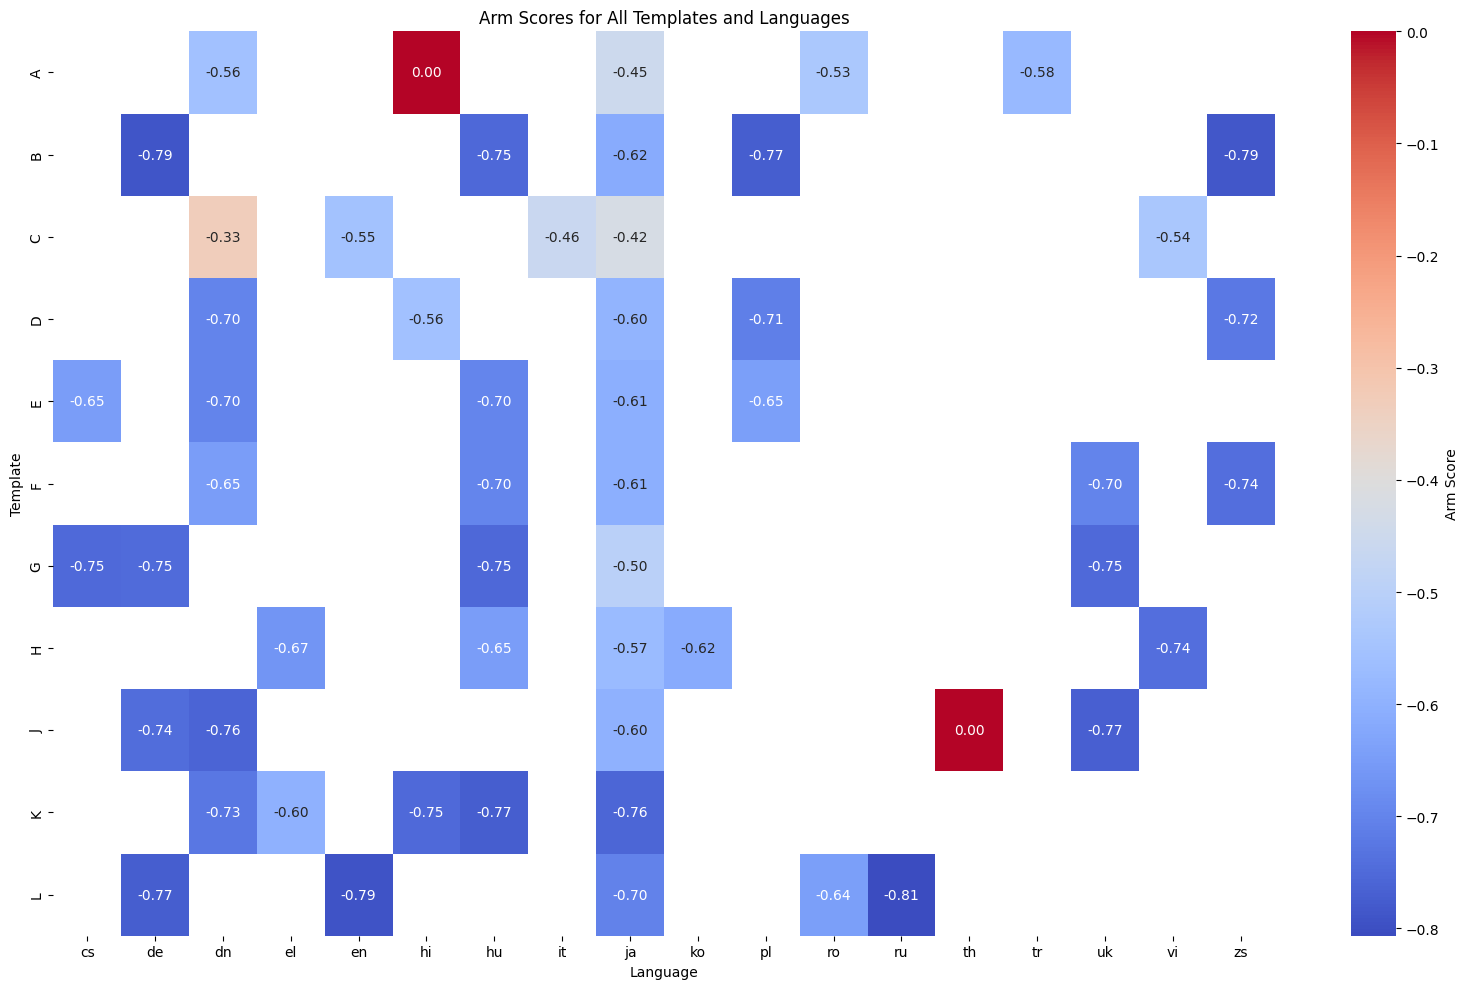

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the arm_score_ui dictionary to a DataFrame
df = pd.DataFrame.from_dict(arm_score_ui, orient='index', columns=['score'])
df.reset_index(inplace=True)
df[['template', 'language']] = pd.DataFrame(df['index'].tolist(), index=df.index)
df.drop(columns=['index'], inplace=True)

top_5_per_template = df.groupby('template').apply(
    lambda x: x.nlargest(5, 'score')
).reset_index(drop=True)


# Pivot the DataFrame for the heatmap
heatmap_data = top_5_per_template.pivot(index='template', columns='language', values='score')

# Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Arm Score'})
plt.title("Arm Scores for All Templates and Languages")
plt.xlabel("Language")
plt.ylabel("Template")
plt.tight_layout()
plt.show()
